In [1]:
import torch
import torchvision
from torch import nn
import time
import torch
import torch.nn.functional as F
from torch import optim
from torch import nn
from einops import rearrange
from torchvision import datasets, transforms
from torch.utils.data import Dataset, SubsetRandomSampler, DataLoader

import argparse
import sys
sys.argv = ['run.py']

import h5py
import copy

import numpy as np
import matplotlib.pylab as plt

In [2]:
parser = argparse.ArgumentParser(description='Pre_train MNIST Example')
parser.add_argument('--batch-size', type=int, default=100, metavar='N',
                    help='input batch size for training (default: 128)')
parser.add_argument('--epochs', type=int, default=100, metavar='N',
                    help='number of epochs to train (default: 10)')
parser.add_argument('--no-cuda', action='store_true', default=False,
                    help='enables CUDA training')
# parser.add_argument('--seed', type=int, default=1, metavar='S',
#                     help='random seed (default: 1)')
# parser.add_argument('--log-interval', type=int, default=20, metavar='N',
#                     help='how many batches to wait before logging training status')
parser.add_argument('--imgage-size', type=int, default=20,help='input image size')

parser.add_argument('--imgage-patch', type=int, default=4,help='segmentation image patch')

parser.add_argument('--channels', type=int, default=2, help='_')

parser.add_argument('--num-class', type=int, default=2,help='num class')

parser.add_argument('--mlp-dim', type=int, default=300, help='_')

parser.add_argument('--num_token',type=int, default=96, help='_')

parser.add_argument('--dropout-rate', type=int, default=0.2, help='_')

parser.add_argument('--learning-rate', type=int, default=1e-4, help='_')

args = parser.parse_args()
args.cuda = not args.no_cuda and torch.cuda.is_available()
device = torch.device("cuda" if args.cuda else "cpu")

In [3]:
#载入数据
data=[]
M_raw=[]

with h5py.File('four_phases_data/124_MT_20size_1T_jiangede.hdf5', 'r') as f:

    for i in np.arange(1,41):   
    
        dataset=f[str(i)+'.0K']
    
        data.append(dataset[:])

        M_raw.append(dataset[:].mean(axis=(0,2,3)).sum())

data=np.array(data)
M_raw=np.array(M_raw)
print(data.shape)

sample_num = data.shape[1]

data_num = data.shape[0]

data=data.reshape(-1, args.channels*args.imgage_size*args.imgage_size)

T = np.linspace(1,50,data_num)
Tc=19

Phase_label=[]

[Phase_label.append(0) if i<Tc else Phase_label.append(1)  for i in range(len(T)) for j in range(sample_num)]

Phase_label=np.array(Phase_label)

#数据做变形,处于0到1之间,并将其和独热码转为tensor
data_set=(data+1)/2

data_set=torch.tensor(data_set).to(torch.float32)
Phase_label=torch.tensor(Phase_label).to(torch.long)

#整合数据与标签
data_all=[[data_set[i], Phase_label[i]] for i in range(sample_num*data_num)]

print(data_set.shape)
print(Phase_label.shape)
print(len(data_all))



#载入数据
data=[]
M_raw_test=[]

with h5py.File('four_phases_data/124_MT_20size_2T_jiangede.hdf5', 'r') as f:

    for i in np.arange(1,41):   
    
        dataset=f[str(i)+'.0K']
    
        data.append(dataset[:])

        M_raw_test.append(dataset[:].mean(axis=(0,2,3)).sum())

data=np.array(data)
M_raw_test=np.array(M_raw_test)
print(data.shape)

sample_num = data.shape[1]

data_num = data.shape[0]

data=data.reshape(-1, args.channels*args.imgage_size*args.imgage_size)

T = np.linspace(1,50,data_num)
Tc=19

Phase_label=[]

[Phase_label.append(0) if i<Tc else Phase_label.append(1)  for i in range(len(T)) for j in range(sample_num)]

Phase_label=np.array(Phase_label)

#数据做变形,处于0到1之间,并将其和独热码转为tensor
data_set=(data+1)/2

data_set=torch.tensor(data_set).to(torch.float32)
Phase_label=torch.tensor(Phase_label).to(torch.long)

#整合数据与标签
data_all_test=[[data_set[i], Phase_label[i]] for i in range(sample_num*data_num)]

print(data_set.shape)
print(Phase_label.shape)
print(len(data_all_test))


(40, 500, 2, 20, 20)
torch.Size([20000, 800])
torch.Size([20000])
20000
(40, 500, 2, 20, 20)
torch.Size([20000, 800])
torch.Size([20000])
20000


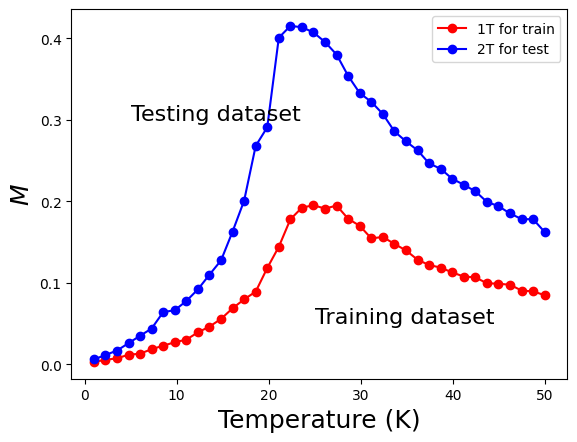

In [4]:
plt.plot(T,M_raw,'ro-',label='1T for train')

plt.plot(T,M_raw_test,'bo-',label='2T for test')

plt.xlabel('Temperature (K)', fontsize=18)
plt.ylabel(r'$M$', fontsize=18)


plt.text(25,0.05,'Training dataset',fontsize=16)
plt.text(5,0.30,'Testing dataset',fontsize=16)


plt.legend()
plt.show()

In [442]:
train_loader = DataLoader(data_all, batch_size = args.batch_size, shuffle=True)
test_loader = DataLoader(data_all_test, batch_size = args.batch_size, shuffle=True )

# shuffled_indices = np.random.permutation(len(data_all))
# train_idx = shuffled_indices[:int(0.8*len(data_all))]
# val_idx = shuffled_indices[int(0.8*len(data_all)):]

# train_loader = DataLoader(data_all, batch_size = args.batch_size, drop_last=False, sampler=SubsetRandomSampler(train_idx))
# test_loader = DataLoader(data_all, batch_size = args.batch_size, drop_last=False, sampler=SubsetRandomSampler(val_idx) )

In [509]:
# discriminator class

class Discriminator(nn.Module):
    
    def __init__(self, v_dim=200,h_dim=500, class_num=4,dropout=0.1):
        # initialise parent pytorch class
        super().__init__()
        
        self.model = nn.Sequential(
            
            nn.Linear(v_dim, h_dim),
            
            # nn.LeakyReLU(),  
            nn.ReLU(),         
            # nn.LayerNorm(h_dim),
            nn.BatchNorm1d(h_dim),
            nn.Dropout(p=dropout),
            # nn.Linear(h_dim, h_dim),
            # nn.Dropout(p=dropout),
            # # nn.LeakyReLU(),  
            # nn.ReLU(),           
            # nn.LayerNorm(h_dim),
            # # nn.BatchNorm1d(h_dim),

            
            nn.Linear(h_dim, class_num),
            # nn.Sigmoid()
            # nn.Softmax()
        )
        
    
    def forward(self, inputs):
        # simply run model
        return self.model(inputs)
    

def Train_model(model, optimizer, data_loader, loss_history,epoch):
    model.train()
    total_samples = len(data_loader)*data_loader.batch_size#len(data_loader.dataset)

    The_loss=0

    for data, target in data_loader:

        
        optimizer.zero_grad()
        data=data.to(device)
        target=target.to(device)

        loss_f = nn.CrossEntropyLoss()
        loss = loss_f(model.forward(data), target)

        The_loss+=loss.detach().item()

        loss.backward()
        optimizer.step()


    loss_history.append(The_loss/len(data_loader))#loss.item()

    if epoch % 10==0 or epoch<=5:
        print('Epoch {}: Average train loss : {:.5f}'.format(epoch,The_loss/len(data_loader)))

def evaluate(model, data_loader, loss_history,Accuracy_rate,epoch):
    model.eval()

    total_samples = len(data_loader)*data_loader.batch_size#len(data_loader.dataset)
    correct_samples = 0
    total_loss = 0

    with torch.no_grad():
        
        for data, target in data_loader:
            data=data.to(device)
            target=target.to(device)
            ###
            # output = F.log_softmax(model(data), dim=1)
            # loss = F.nll_loss(output, target, reduction='sum')
            loss_f = nn.CrossEntropyLoss()
            loss = loss_f(model(data),target)

            # _, pred = torch.max(output, dim=0)#

            total_loss += loss.item()
            # correct_samples += pred.eq(target).sum()
            ###
            output_f=nn.Softmax(dim=-1)
            predicted = output_f(model.forward(data)).argmax(dim=-1)

            # total += target.size(0)
            correct_samples += predicted.eq(target).sum().item()


    avg_loss = total_loss / len(data_loader)#total_samples
    loss_history.append(avg_loss)
    Accuracy = (100.0 * correct_samples / total_samples)
    Accuracy_rate.append(Accuracy)

    if epoch % 10 ==0 or epoch<=5:

        print('Epoch {}: '.format(epoch)+'Average test loss: ' + '{:.5f}'.format(avg_loss) +
            '  Accuracy:' + '{:5}'.format(correct_samples) + '/' +
            '{:5}'.format(total_samples) + ' (' +
            '{:4.2f}'.format(Accuracy) + '%)\n')


In [513]:
%%time


model_D = Discriminator(v_dim=args.channels*args.imgage_size**2, h_dim=args.mlp_dim, class_num=args.num_class,dropout=0.4)#args.dropout_rate

model_D.to(device)
optimizer = optim.Adam(model_D.parameters(), lr=args.learning_rate)

train_loss_history, test_loss_history, Accuracy_rate = [], [], []
for epoch in range(1, args.epochs + 1):#5
    # print('Epoch:', epoch)
    Train_model(model_D, optimizer, train_loader, train_loss_history,epoch)
    evaluate(model_D, test_loader, test_loss_history,Accuracy_rate,epoch)

Epoch 1: Average train loss : 0.20124
Epoch 1: Average test loss: 0.22131  Accuracy:18516/20000 (92.58%)

Epoch 2: Average train loss : 0.11745
Epoch 2: Average test loss: 0.20897  Accuracy:18607/20000 (93.03%)

Epoch 3: Average train loss : 0.09023
Epoch 3: Average test loss: 0.19881  Accuracy:18651/20000 (93.25%)

Epoch 4: Average train loss : 0.07626
Epoch 4: Average test loss: 0.18540  Accuracy:18714/20000 (93.57%)

Epoch 5: Average train loss : 0.06432
Epoch 5: Average test loss: 0.18525  Accuracy:18724/20000 (93.62%)

Epoch 10: Average train loss : 0.03971
Epoch 10: Average test loss: 0.18374  Accuracy:18705/20000 (93.53%)

Epoch 20: Average train loss : 0.03761
Epoch 20: Average test loss: 0.20842  Accuracy:18729/20000 (93.64%)

Epoch 30: Average train loss : 0.02763
Epoch 30: Average test loss: 0.19994  Accuracy:18787/20000 (93.94%)

Epoch 40: Average train loss : 0.02592
Epoch 40: Average test loss: 0.18753  Accuracy:18758/20000 (93.79%)

Epoch 50: Average train loss : 0.02706

In [514]:
model_D

Discriminator(
  (model): Sequential(
    (0): Linear(in_features=800, out_features=300, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=300, out_features=2, bias=True)
  )
)

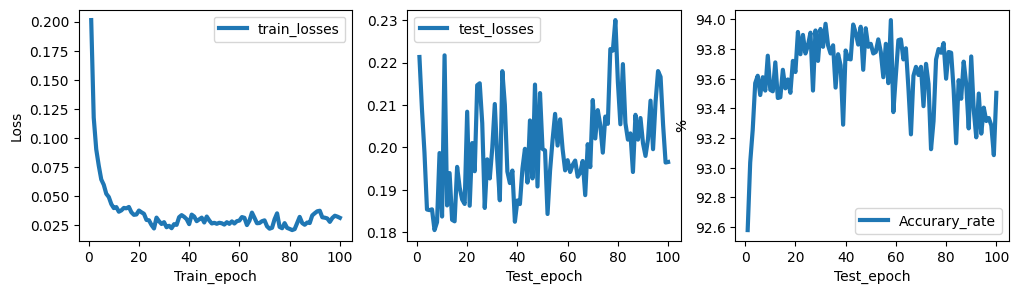

In [515]:
fig=plt.figure(figsize=(12,3))

ax1=plt.subplot(131)
ax1.plot(np.arange(1,len(train_loss_history)+1),train_loss_history, linewidth=3, linestyle='-', label='train_losses')
ax1.set_xlabel('Train_epoch')
ax1.set_ylabel('Loss')
ax1.legend()

ax2=plt.subplot(132)
ax2.plot(np.arange(1,len(test_loss_history)+1),test_loss_history, linewidth=3, linestyle='-', label='test_losses')
ax2.set_xlabel('Test_epoch')
ax2.legend()

ax3=plt.subplot(133)
ax3.plot(np.arange(1,len(Accuracy_rate)+1),Accuracy_rate, linewidth=3, linestyle='-', label='Accurary_rate')
ax3.set_xlabel('Test_epoch')
ax3.set_ylabel('%')
ax3.legend()

plt.show()

In [565]:
for i in range(0,20000,500):
    A_test=data_all_test[i:i+500]
    model_D.eval()
    all=0
    with torch.no_grad():
        for img ,label in A_test:
            img=img.cuda()
            img=img.view(-1,800)
            A=nn.Softmax(dim=-1)(model_D(img)).argmax(dim=-1)
            all+=A
            # print(A)
        print('{} K The number of PM by model is {}'.format((int(i/500+1)), all.cpu().numpy()))


1 K The number of PM by model is [0]
2 K The number of PM by model is [0]
3 K The number of PM by model is [0]
4 K The number of PM by model is [0]
5 K The number of PM by model is [0]
6 K The number of PM by model is [0]
7 K The number of PM by model is [0]
8 K The number of PM by model is [0]
9 K The number of PM by model is [0]
10 K The number of PM by model is [0]
11 K The number of PM by model is [0]
12 K The number of PM by model is [0]
13 K The number of PM by model is [0]
14 K The number of PM by model is [0]
15 K The number of PM by model is [0]
16 K The number of PM by model is [2]
17 K The number of PM by model is [202]
18 K The number of PM by model is [347]
19 K The number of PM by model is [337]
20 K The number of PM by model is [409]
21 K The number of PM by model is [404]
22 K The number of PM by model is [446]
23 K The number of PM by model is [461]
24 K The number of PM by model is [459]
25 K The number of PM by model is [484]
26 K The number of PM by model is [482]
2